In [3]:
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.formula.api import ols



# Словарь файлов и соответствующих им названий столбцов
files = {
    'tksg.xlsx': 'TCSG',
    'yandex.xlsx': 'YDEX',
    'vk.xlsx': 'VKCO',
    'rostelecom.xlsx': 'RTKM',
    'usd_rub.xlsx': 'USD_RUB',
    'brent.xlsx': 'Brent',
    'bitcoin.xlsx': 'BTC_RUB'
}

# 1. Загрузка данных
dfs = []

for file, col_name in files.items():
    df = pd.read_excel(file)
    df.columns = ['Дата', col_name]
    df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True).dt.date  # Только дата, без времени
    df.set_index('Дата', inplace=True)
    dfs.append(df)

# 2. Объединение всех DataFrame по индексу (дате) через inner join
combined_df = pd.concat(dfs, axis=1, join='inner')
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'Дата'}, inplace=True)

# Сохраняем объединённые данные в Excel
combined_df.to_excel('combined_data.xlsx', index=False)

# 3. Преобразуем числовые столбцы к float (корректная обработка запятых)
numeric_cols = combined_df.columns[1:]

for col in numeric_cols:
    combined_df[col] = pd.to_numeric(
        combined_df[col].astype(str).str.replace(',', '.', regex=False),
        errors='coerce'
    )

# 4. Удаление выбросов методом IQR
cleaned_df = combined_df.copy()

for col in numeric_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Замена выбросов на границы
    cleaned_df[col] = np.where(cleaned_df[col] < lower_bound, lower_bound, cleaned_df[col])
    cleaned_df[col] = np.where(cleaned_df[col] > upper_bound, upper_bound, cleaned_df[col])

# Сохраняем очищенные данные в Excel
cleaned_df.to_excel('cleaned_data.xlsx', index=False)

# 5. Нормализация Z-Score
normalized_df = cleaned_df.copy()

for col in numeric_cols:
    mean = normalized_df[col].mean()
    std = normalized_df[col].std()
    normalized_df[col] = (normalized_df[col] - mean) / std

# Сохраняем нормализованные данные в Excel
normalized_df.to_excel('normalized_data.xlsx', index=False)

# --- Вывод первых и последних 5 строк для каждого датасета ---
print("🔹 combined_df — первые 5 строк:")
print(combined_df.head().to_string(index=False))
print("\n🔹 combined_df — последние 5 строк:")
print(combined_df.tail().to_string(index=False))

print("\n\n🔹 cleaned_df — первые 5 строк:")
print(cleaned_df.head().to_string(index=False))
print("\n🔹 cleaned_df — последние 5 строки:")
print(cleaned_df.tail().to_string(index=False))

print("\n\n🔹 normalized_df — первые 5 строк:")
print(normalized_df.head().to_string(index=False))
print("\n🔹 normalized_df — последние 5 строки:")
print(normalized_df.tail().to_string(index=False))

🔹 combined_df — первые 5 строк:
      Дата   TCSG   YDEX  VKCO  RTKM  USD_RUB  Brent      BTC_RUB
2025-04-28 3279.8 4283.0 272.9 59.85  82.6549  65.86 94463.901059
2025-04-25 3284.4 4371.5 283.6 61.47  82.8559  66.87 93552.379715
2025-04-24 3212.0 4293.0 272.8 60.94  82.3637  66.55 93533.403436
2025-04-23 3214.6 4285.0 272.5 59.70  81.4620  66.12 93670.507457
2025-04-22 3276.2 4362.5 274.4 60.86  80.7597  67.44 91201.132400

🔹 combined_df — последние 5 строк:
      Дата   TCSG   YDEX   VKCO  RTKM  USD_RUB  Brent  BTC_RUB
2020-07-10 1504.4 4779.4 1811.8 87.03  70.8800  43.24  9278.81
2020-07-09 1470.2 4975.0 1808.0 85.60  71.2379  42.35  9277.97
2020-07-08 1460.0 4360.0 1838.6 86.60  72.1719  43.29  9428.33
2020-07-07 1490.0 3598.8 1873.0 88.00  71.3409  43.08  9252.28
2020-07-02 1447.0 3103.8 1666.0 87.63  70.4413  43.14  9123.41


🔹 cleaned_df — первые 5 строк:
      Дата   TCSG   YDEX  VKCO  RTKM  USD_RUB  Brent      BTC_RUB
2025-04-28 3279.8 4283.0 272.9 59.85  82.6549  65.86 94463.

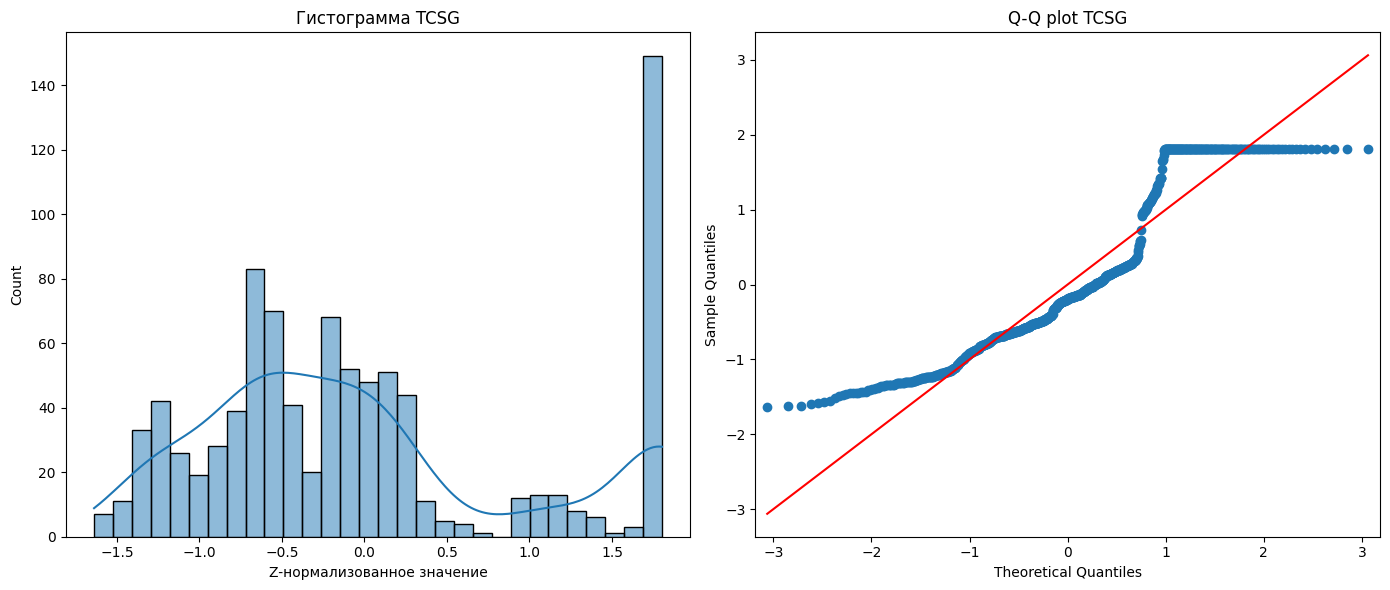

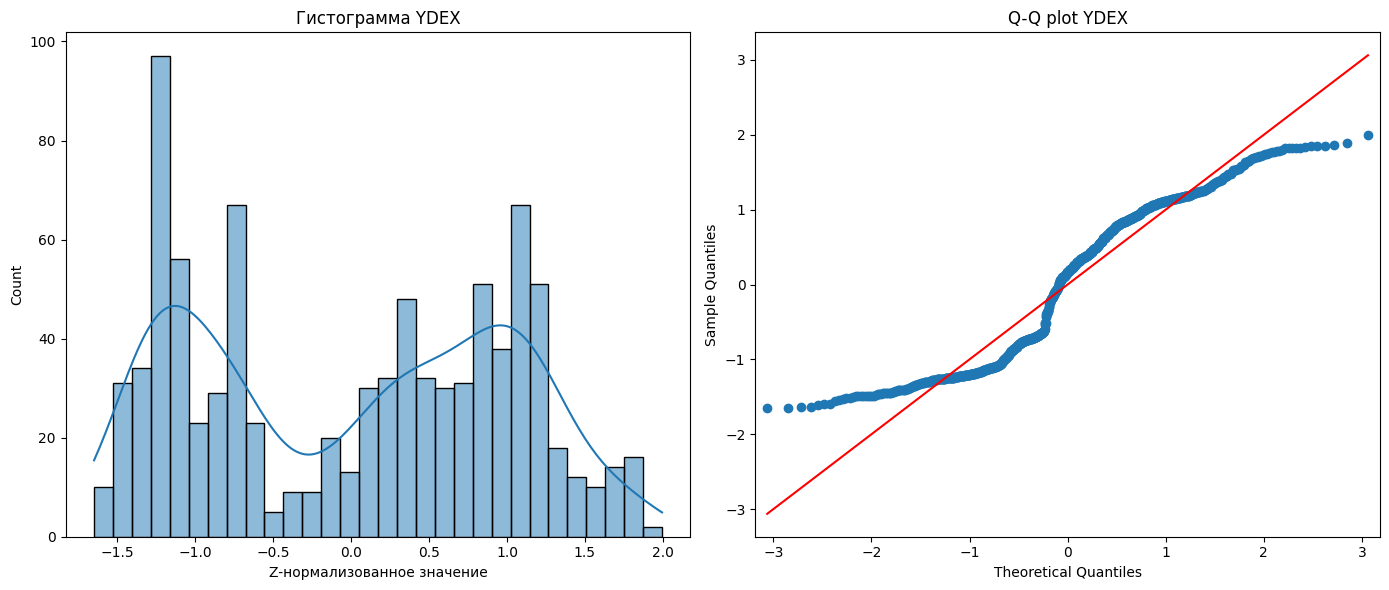

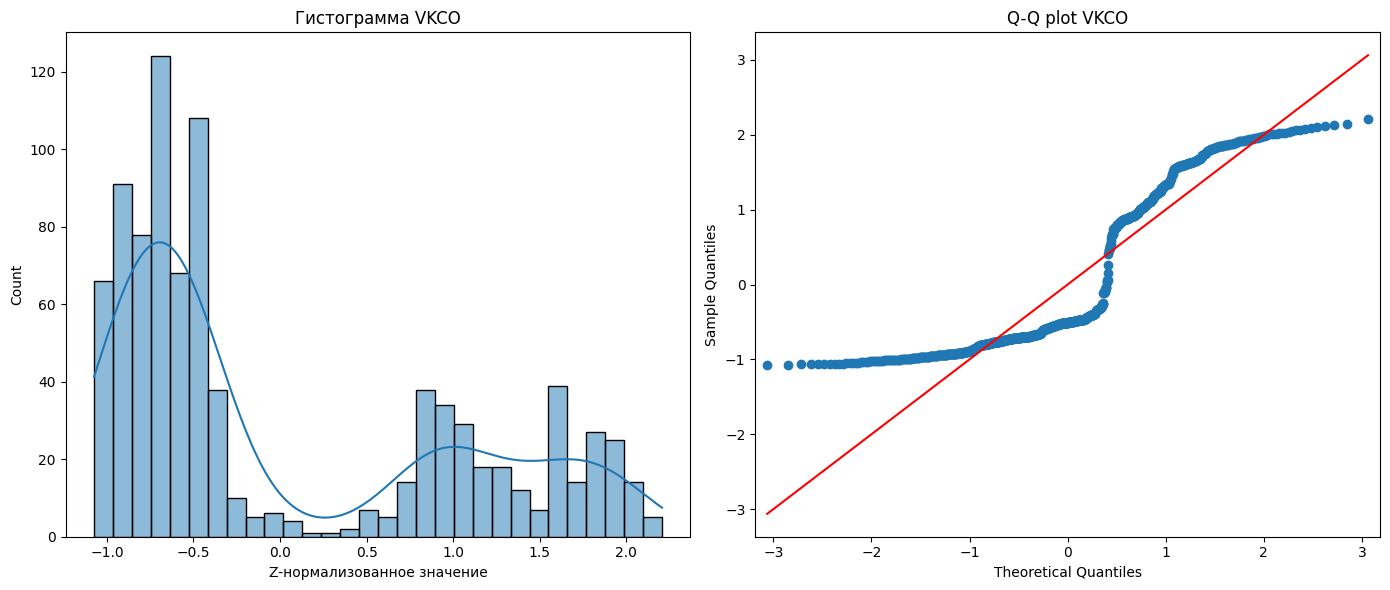

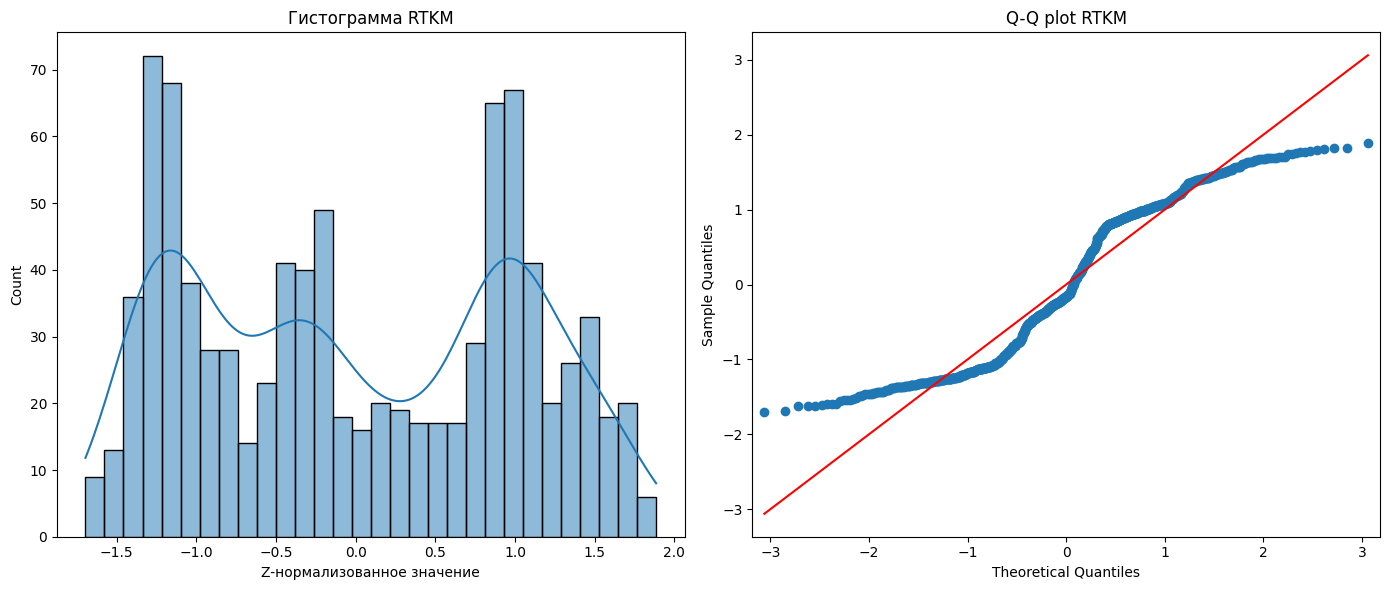

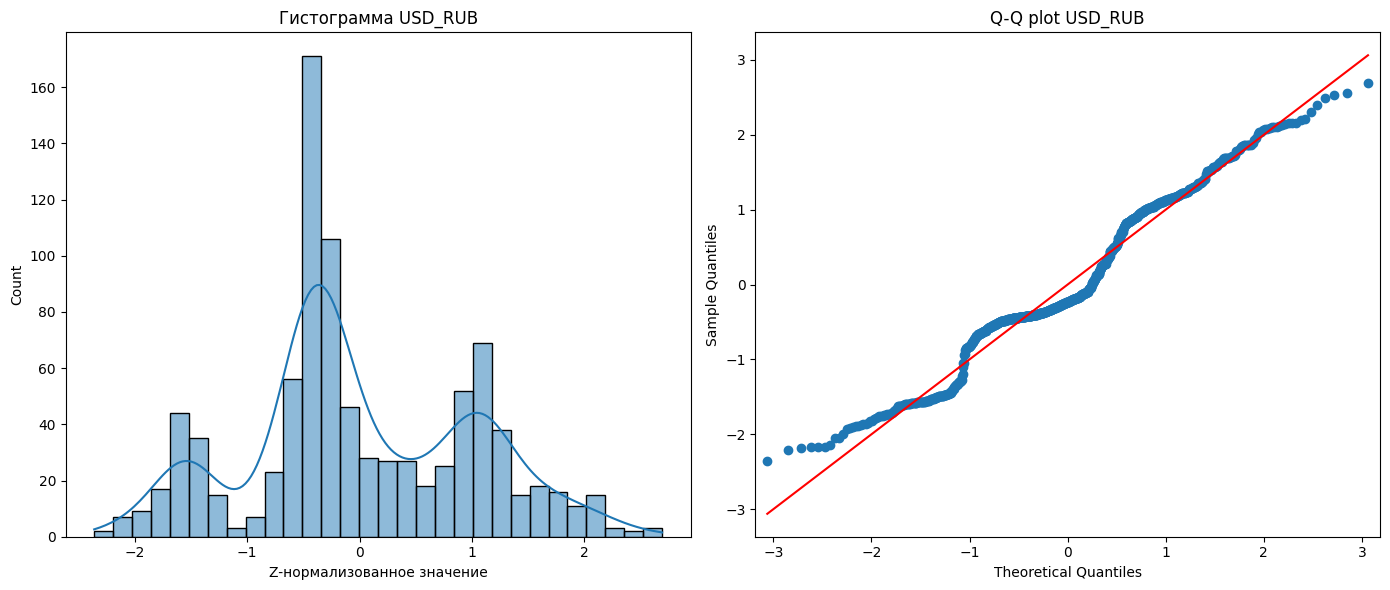

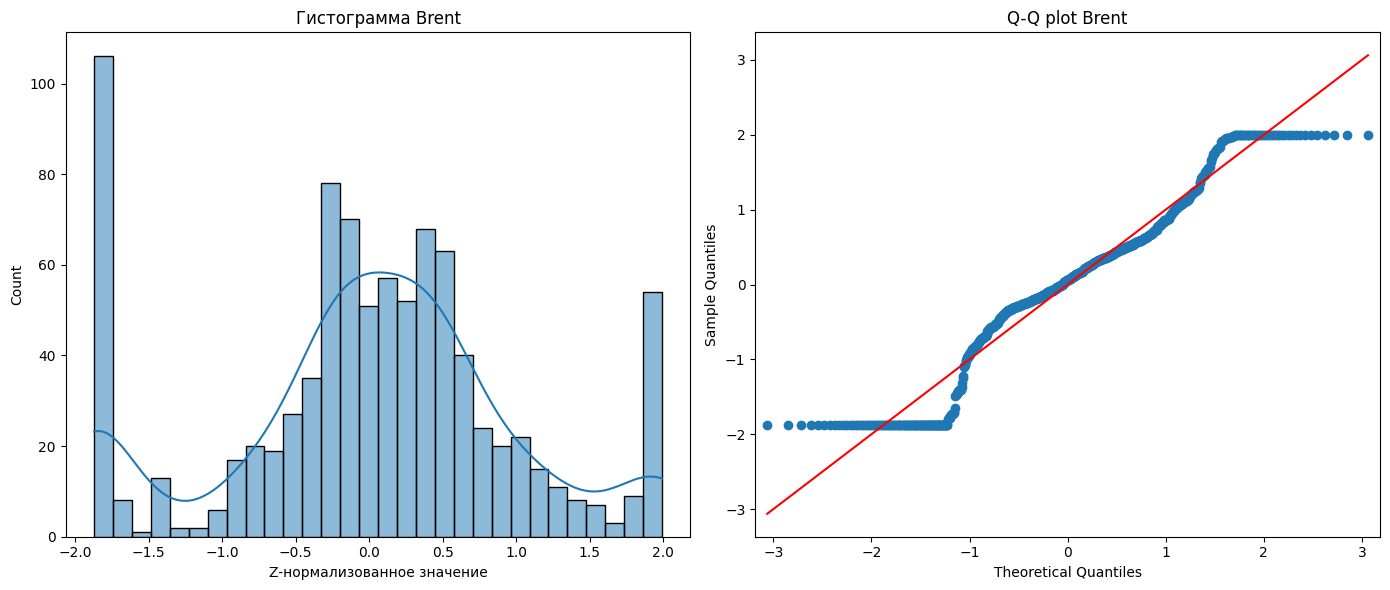

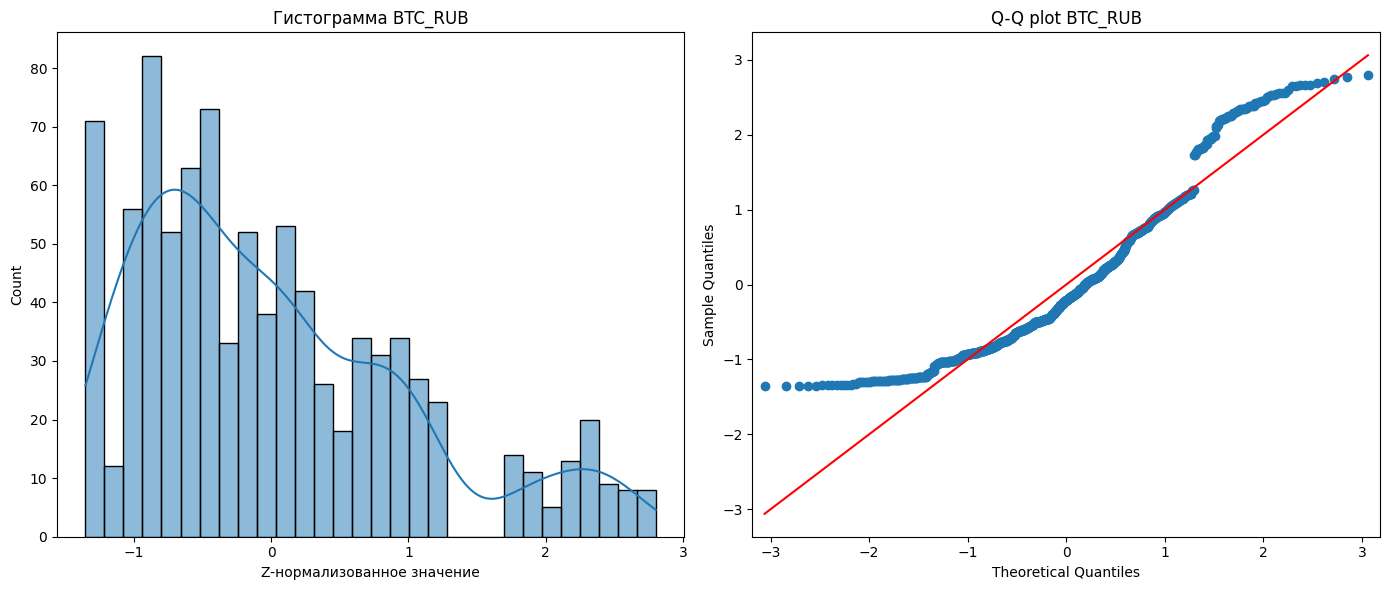

In [4]:

factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_RUB']

for factor in factors:
    plt.figure(figsize=(14, 6))

    # Гистограмма (слева)
    plt.subplot(1, 2, 1)
    sns.histplot(normalized_df[factor], kde=True, bins=30)  # Исправлено: normalized_df[factor]
    plt.title(f'Гистограмма {factor}')
    plt.xlabel('Z-нормализованное значение')

    # Q-Q plot (справа)
    plt.subplot(1, 2, 2)
    sm.qqplot(normalized_df[factor].dropna(), line='s', ax=plt.gca())  # Исправлено: normalized_df[factor]
    plt.title(f'Q-Q plot {factor}')

    plt.tight_layout()
    plt.show()

In [5]:

import pandas as pd
from scipy.stats import spearmanr
import numpy as np

# Загрузка нормализованного датафрейма
# normalized_df = pd.read_excel('normalized_data.xlsx')

factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_RUB']

# Создаем матрицы
corr_matrix = pd.DataFrame(index=factors, columns=factors, dtype=float)
p_matrix = pd.DataFrame(index=factors, columns=factors, dtype=str)  # Для строкового представления

for i in factors:
    for j in factors:
        corr, p_value = spearmanr(normalized_df[i], normalized_df[j])
        corr_matrix.loc[i, j] = round(corr, 2)
        
        # Улучшенное форматирование p-value
        if p_value < 1e-323:
            p_matrix.loc[i, j] = "<1e-323" 
        elif p_value < 0.0001:
            p_matrix.loc[i, j] = f"{p_value:.1e}".replace("e-0", "e-")  # 1.2e-15
        else:
            p_matrix.loc[i, j] = f"{p_value:.4f}"

print("\n🔹 Матрица ранговой корреляции Спирмена:")
print(corr_matrix)

print("\n🔹 Матрица p-value для корреляций:")
print(p_matrix)

# Сохранение (опционально)
corr_matrix.to_excel('spearman_correlation_matrix.xlsx')
p_matrix.to_excel('spearman_pvalue_matrix.xlsx')


🔹 Матрица ранговой корреляции Спирмена:
         TCSG  YDEX  VKCO  RTKM  USD_RUB  Brent  BTC_RUB
TCSG     1.00  0.47  0.25  0.37     0.13  -0.01     0.52
YDEX     0.47  1.00  0.63  0.77     0.06  -0.63     0.36
VKCO     0.25  0.63  1.00  0.82    -0.11  -0.59    -0.27
RTKM     0.37  0.77  0.82  1.00     0.10  -0.56     0.16
USD_RUB  0.13  0.06 -0.11  0.10     1.00  -0.14     0.53
Brent   -0.01 -0.63 -0.59 -0.56    -0.14   1.00     0.01
BTC_RUB  0.52  0.36 -0.27  0.16     0.53   0.01     1.00

🔹 Матрица p-value для корреляций:
            TCSG      YDEX      VKCO      RTKM  USD_RUB     Brent  BTC_RUB
TCSG     <1e-323   1.3e-51   1.6e-14   3.5e-31   5.3e-5    0.8197  1.7e-63
YDEX     1.3e-51   <1e-323  7.3e-102  3.9e-182   0.0583  1.4e-102  1.5e-28
VKCO     1.6e-14  7.3e-102   <1e-323  1.3e-220   0.0012   9.2e-88  4.2e-17
RTKM     3.5e-31  3.9e-182  1.3e-220   <1e-323   0.0022   4.1e-76   1.4e-6
USD_RUB   5.3e-5    0.0583    0.0012    0.0022  <1e-323    1.9e-5  5.1e-67
Brent     0.8197  

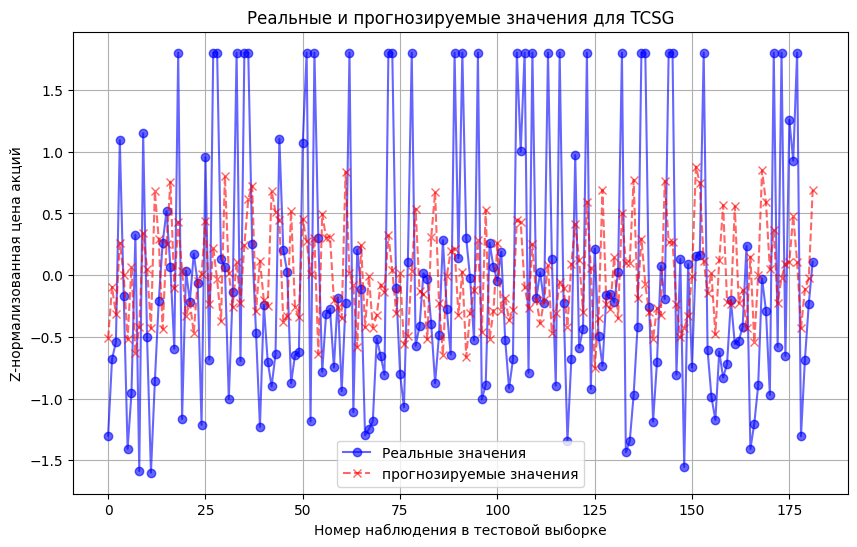

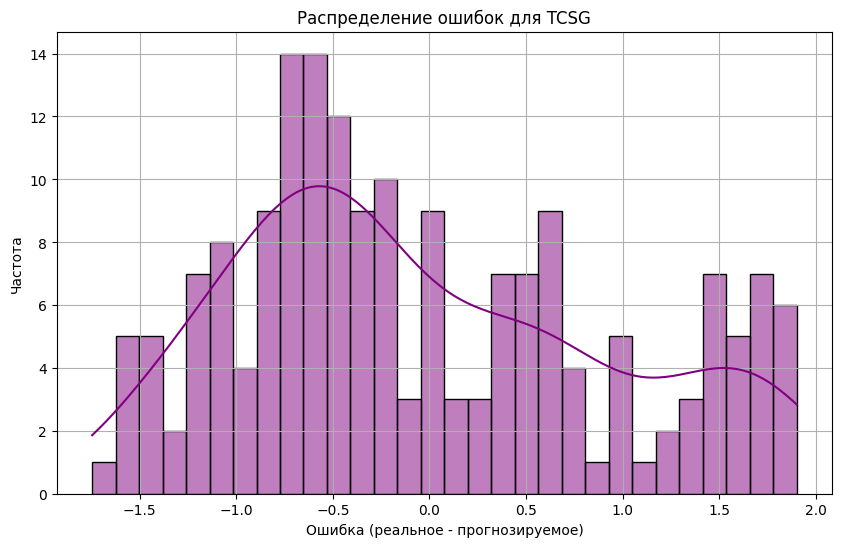

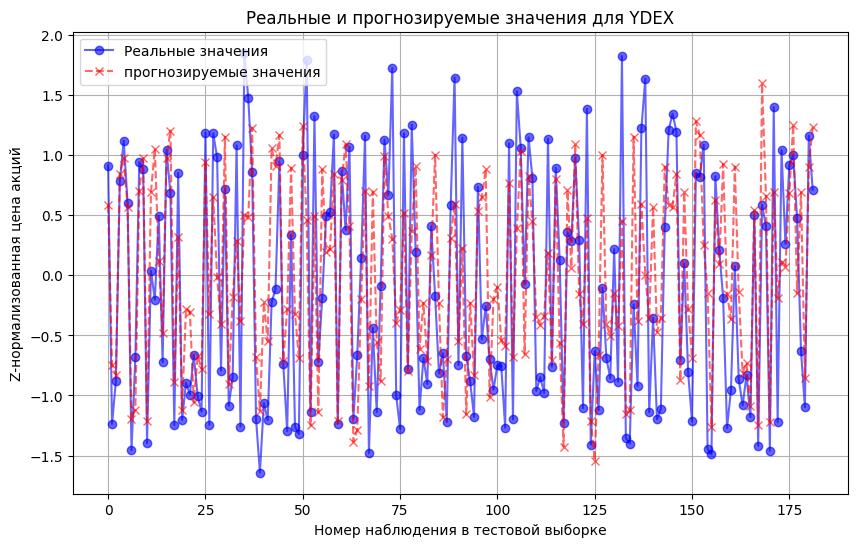

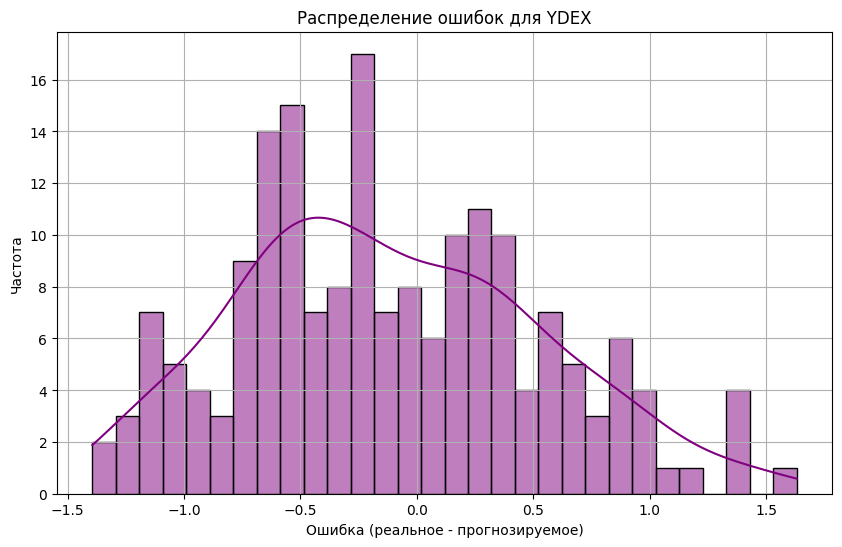

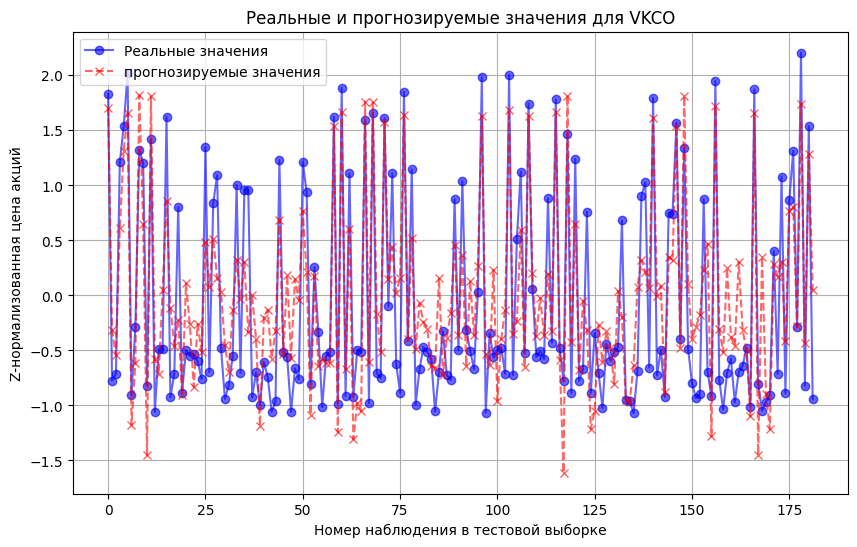

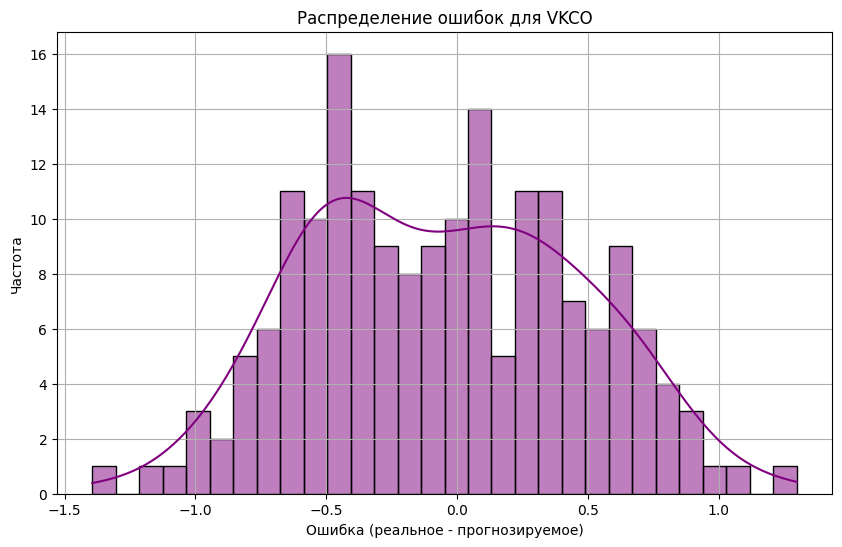

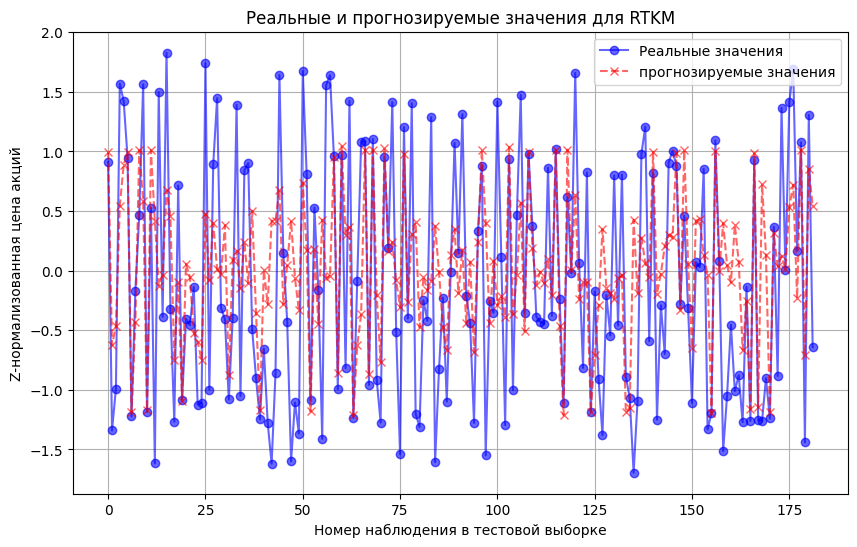

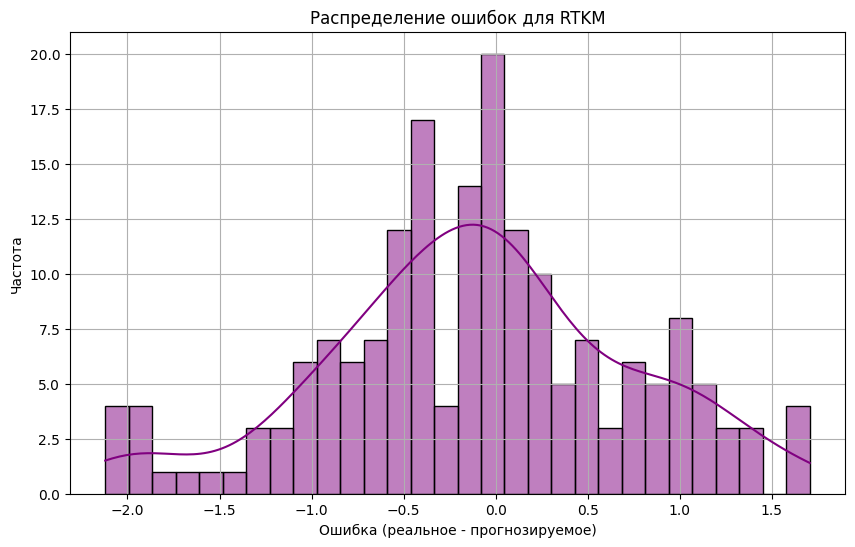

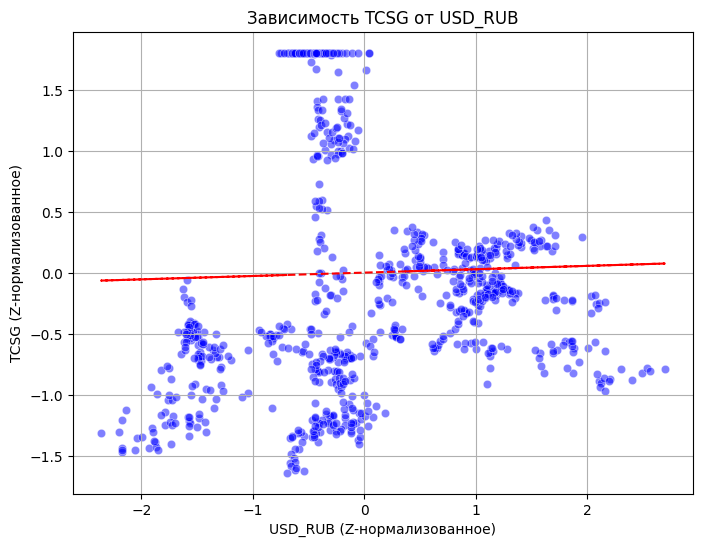

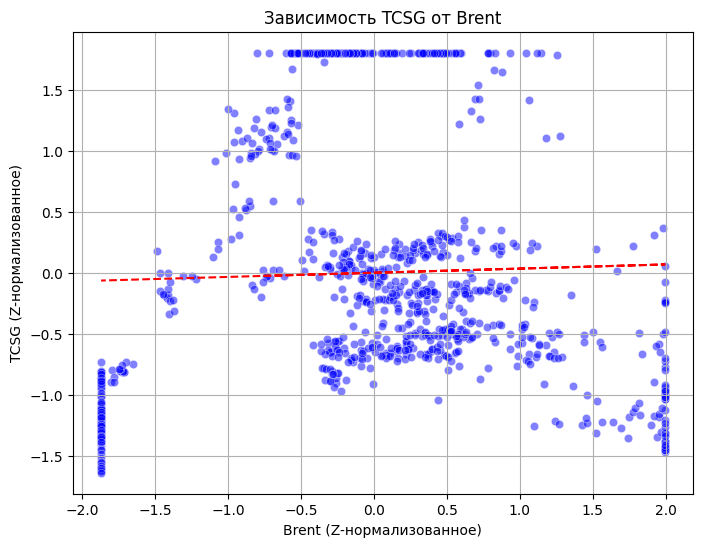

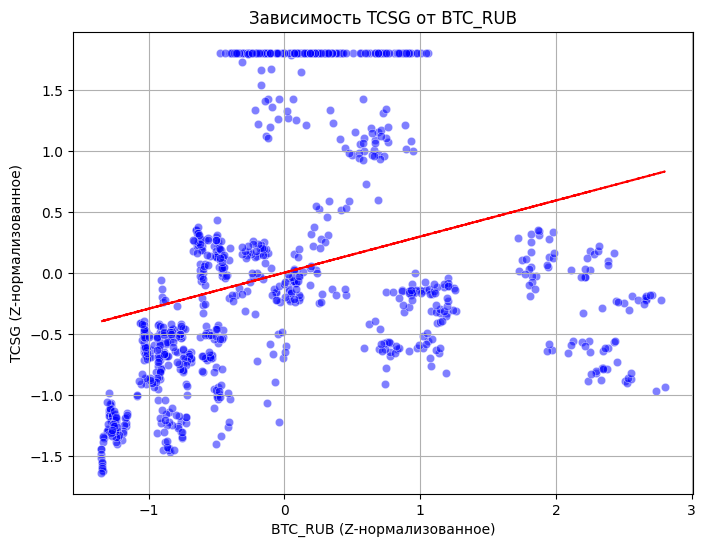

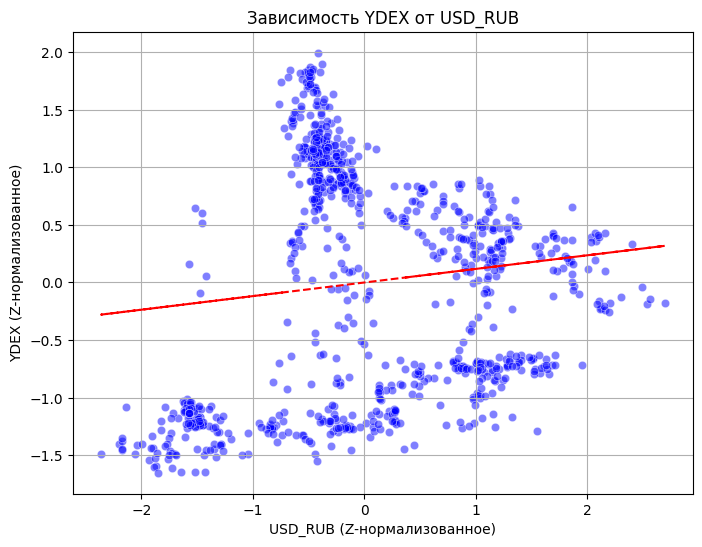

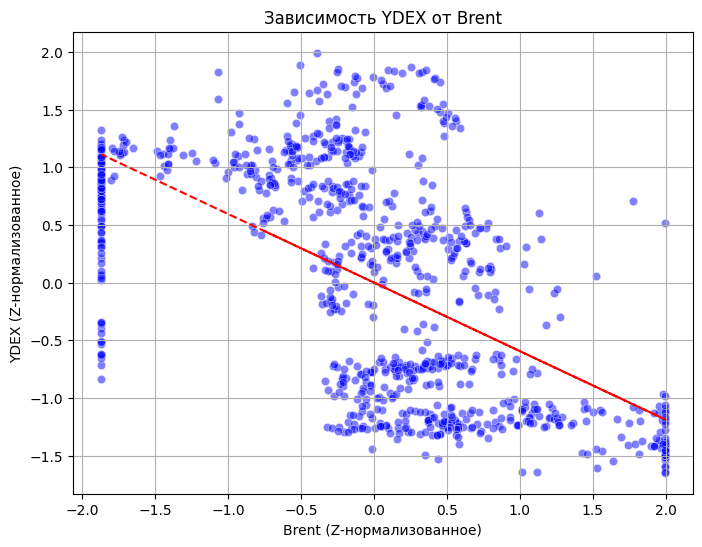

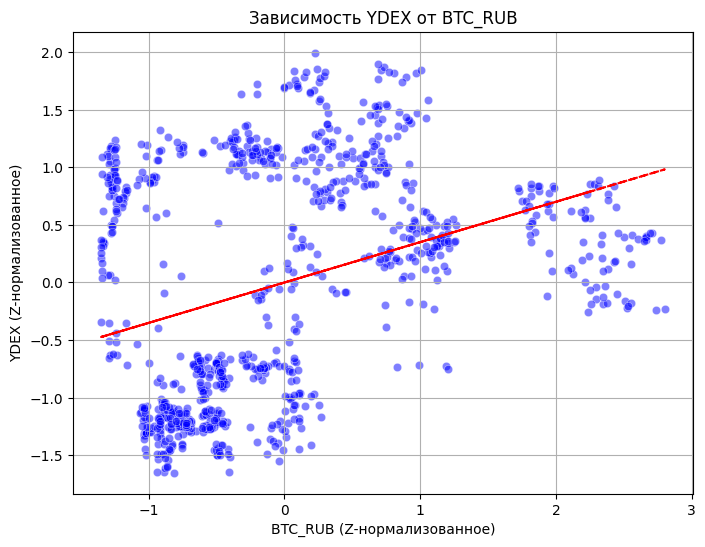

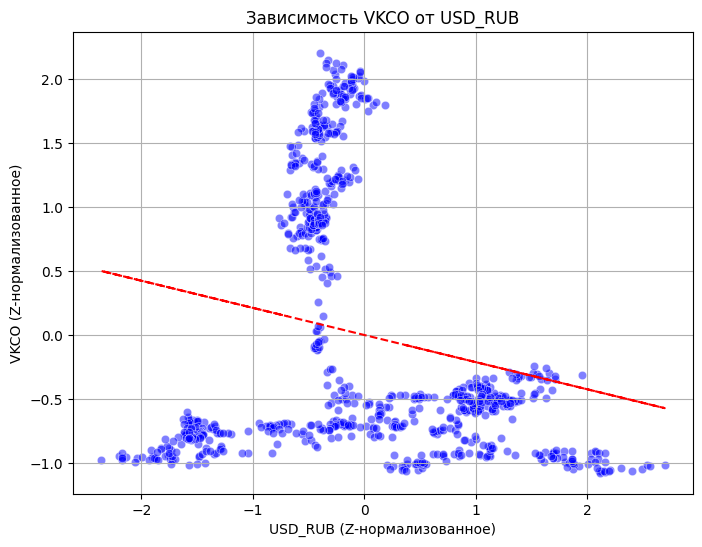

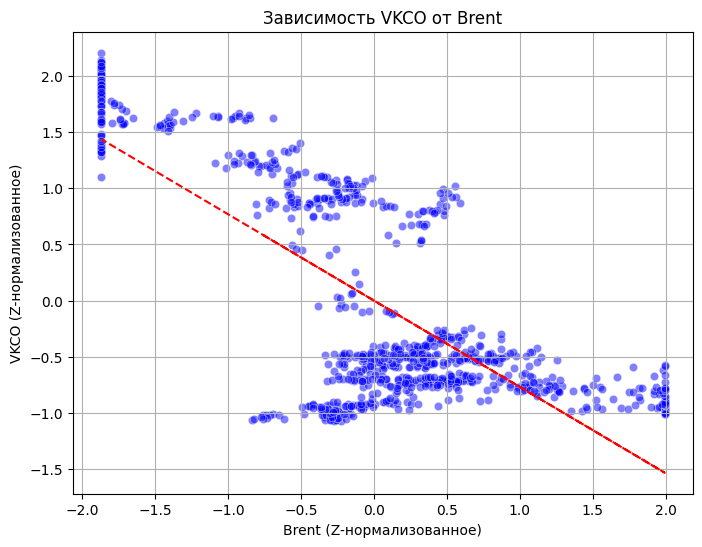

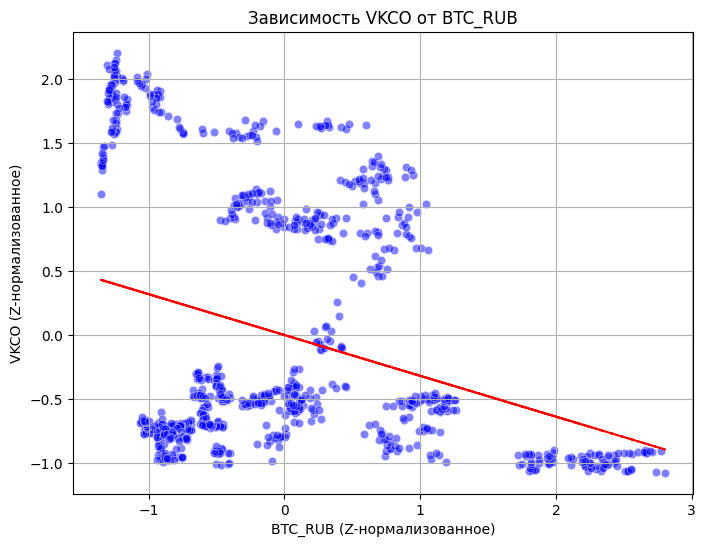

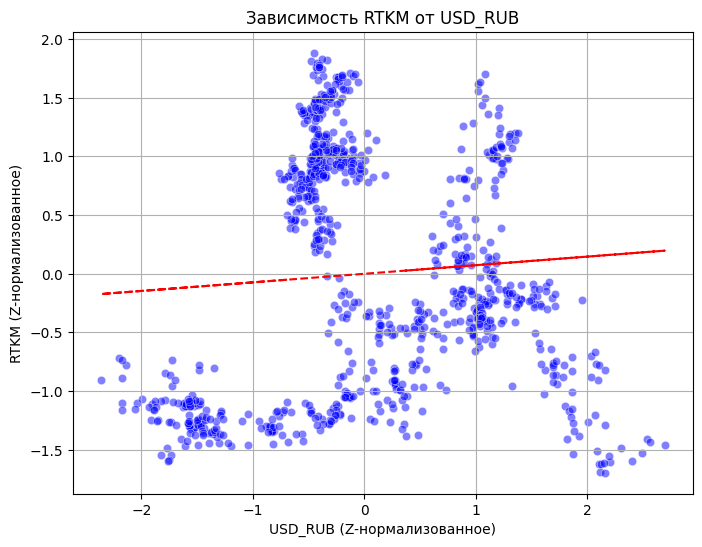

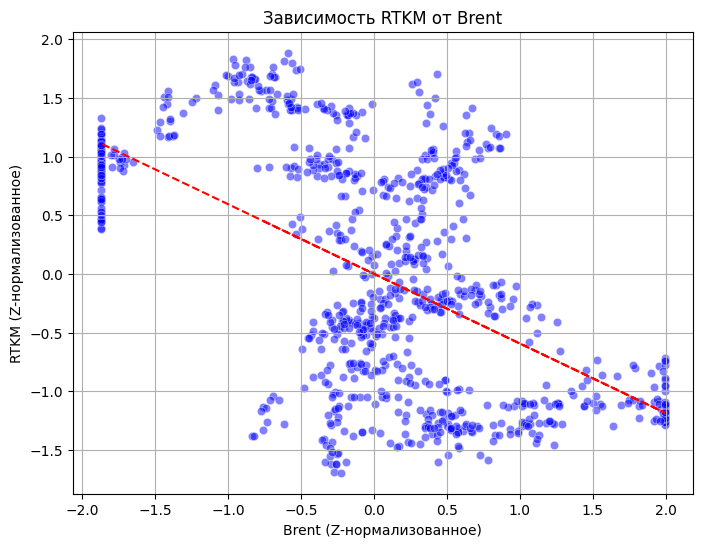

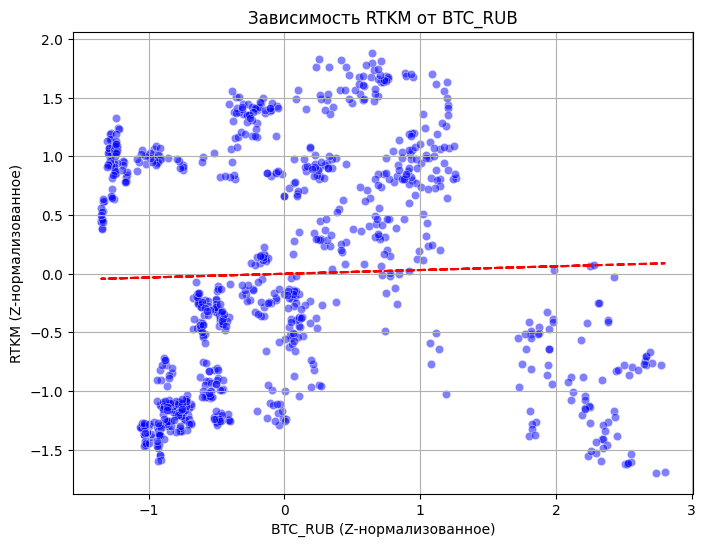


Модель для TCSG:
Коэффициенты регрессии:
  USD_RUB: -0.2508
  Brent: -0.0256
  BTC_RUB: 0.4756
Свободный член (intercept): 0.0071
Средняя абсолютная ошибка (MAE): 0.8143
Средняя квадратичная ошибка (MSE): 0.9194

Модель для YDEX:
Коэффициенты регрессии:
  USD_RUB: -0.3327
  Brent: -0.6898
  BTC_RUB: 0.6172
Свободный член (intercept): 0.0240
Средняя абсолютная ошибка (MAE): 0.5448
Средняя квадратичная ошибка (MSE): 0.4249

Модель для VKCO:
Коэффициенты регрессии:
  USD_RUB: -0.2507
  Brent: -0.8018
  BTC_RUB: -0.1049
Свободный член (intercept): 0.0118
Средняя абсолютная ошибка (MAE): 0.4393
Средняя квадратичная ошибка (MSE): 0.2711

Модель для RTKM:
Коэффициенты регрессии:
  USD_RUB: -0.0618
  Brent: -0.6118
  BTC_RUB: 0.1448
Свободный член (intercept): 0.0220
Средняя абсолютная ошибка (MAE): 0.6382
Средняя квадратичная ошибка (MSE): 0.6867

Результаты сохранены в 'regression_results.xlsx'


In [6]:


# Предполагается, что normalized_df уже создан в предыдущих шагах
# Если нужно загрузить из файла, раскомментируйте:
# normalized_df = pd.read_excel('normalized_data.xlsx')

# Список зависимых и независимых переменных
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_RUB']
X = normalized_df[independent_vars]

# Словарь для хранения результатов
results = {}

# Построение моделей и визуализаций
for y_var in dependent_vars:
    y = normalized_df[y_var]
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Обучение модели
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Прогнозирование
    y_pred = model.predict(X_test)
    
    # Оценка качества
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Сохранение результатов
    results[y_var] = {
        'coefficients': dict(zip(independent_vars, model.coef_)),
        'intercept': model.intercept_,
        'MAE': mae,
        'MSE': mse,
        'y_test': y_test,
        'y_pred': y_pred,
        'X_test': X_test
    }
    
    # График 1: Реальные vs Предсказанные значения
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Реальные значения', color='blue', marker='o', linestyle='-', alpha=0.6)
    plt.plot(y_pred, label='прогнозируемые значения', color='red', marker='x', linestyle='--', alpha=0.6)
    plt.title(f'Реальные и прогнозируемые значения для {y_var}')
    plt.xlabel('Номер наблюдения в тестовой выборке')
    plt.ylabel('Z-нормализованная цена акций')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'prediction_plot_{y_var}.png')
    plt.show()
    
    # График 2: Гистограмма ошибок
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color='purple')
    plt.title(f'Распределение ошибок для {y_var}')
    plt.xlabel('Ошибка (реальное - прогнозируемое)')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.savefig(f'error_histogram_{y_var}.png')
    plt.show()

# Графики регрессии (диаграммы рассеяния с линиями регрессии)
for y_var in dependent_vars:
    y = normalized_df[y_var]
    for x_var in independent_vars:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=normalized_df[x_var], y=y, color='blue', alpha=0.5)
        # Линия регрессии
        z = np.polyfit(normalized_df[x_var], y, 1)
        p = np.poly1d(z)
        plt.plot(normalized_df[x_var], p(normalized_df[x_var]), color='red', linestyle='--')
        plt.title(f'Зависимость {y_var} от {x_var}')
        plt.xlabel(f'{x_var} (Z-нормализованное)')
        plt.ylabel(f'{y_var} (Z-нормализованное)')
        plt.grid(True)
        plt.savefig(f'regression_plot_{y_var}_{x_var}.png')
        plt.show()

# Вывод результатов
for y_var, metrics in results.items():
    print(f"\nМодель для {y_var}:")
    print("Коэффициенты регрессии:")
    for feature, coef in metrics['coefficients'].items():
        print(f"  {feature}: {coef:.4f}")
    print(f"Свободный член (intercept): {metrics['intercept']:.4f}")
    print(f"Средняя абсолютная ошибка (MAE): {metrics['MAE']:.4f}")
    print(f"Средняя квадратичная ошибка (MSE): {metrics['MSE']:.4f}")

# Сохранение результатов в Excel
results_df = pd.DataFrame({
    'Компания': [],
    'USD_RUB (β₁)': [],
    'Brent (β₂)': [],
    'BTC_RUB (β₃)': [],
    'Intercept': [],
    'MAE': [],
    'MSE': []
})

for y_var, metrics in results.items():
    row = {
        'Компания': y_var,
        'USD_RUB (β₁)': metrics['coefficients']['USD_RUB'],
        'Brent (β₂)': metrics['coefficients']['Brent'],
        'BTC_RUB (β₃)': metrics['coefficients']['BTC_RUB'],
        'Intercept': metrics['intercept'],
        'MAE': metrics['MAE'],
        'MSE': metrics['MSE']
    }
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

results_df.to_excel('regression_results.xlsx', index=False)
print("\nРезультаты сохранены в 'regression_results.xlsx'")

In [7]:
# Подготовка данных
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
results_anova = []
columns = ['Источник', 'Сумма квадратов', 'Степени свободы', 'F-статистика', 'p-значение']

for y_var in dependent_vars:
    # Формирование модели
    formula = f'{y_var} ~ USD_RUB + Brent + BTC_RUB'
    model = ols(formula, data=normalized_df).fit()
    
    # Дисперсионный анализ
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Форматирование таблицы
    anova_table = anova_table.reset_index().rename(columns={
        'index': 'Источник',
        'sum_sq': 'Сумма квадратов',
        'df': 'Степени свободы',
        'F': 'F-статистика',
        'PR(>F)': 'p-значение'
    })
    
    # Форматирование чисел
    anova_table['Сумма квадратов'] = anova_table['Сумма квадратов'].apply(lambda x: f"{x:.4f}")
    anova_table['F-статистика'] = anova_table['F-статистика'].apply(lambda x: f"{x:.4f}" if not pd.isna(x) else "")
    anova_table['p-значение'] = anova_table['p-значение'].apply(
        lambda x: "<0.000001" if x < 0.000001 else f"{x:.6f}" if not pd.isna(x) else ""
    )
    
    # Замена англоязычных названий
    anova_table['Источник'] = anova_table['Источник'].replace({
        'USD_RUB': 'Курс USD/RUB',
        'Brent': 'Цена нефти Brent',
        'BTC_RUB': 'Курс BTC/RUB',
        'Residual': 'Остатки'
    })
    
    # Добавление заголовка
    header_row = pd.DataFrame([[f'Результаты дисперсионного анализа (ANOVA) для {y_var}', '', '', '', '']], 
                              columns=columns)
    results_anova.append(header_row)
    results_anova.append(anova_table)
    
    # Вывод результатов
    print(f"\nРезультаты дисперсионного анализа для {y_var}:")
    print(anova_table.to_string(index=False))

# Объединение всех результатов
final_df = pd.concat(results_anova, ignore_index=True)

# Сохранение в Excel
final_df.to_excel('anova_results_rus.xlsx', sheet_name='ANOVA_Результаты', index=False)


Результаты дисперсионного анализа для TCSG:
        Источник Сумма квадратов  Степени свободы F-статистика p-значение
    Курс USD/RUB         34.6068              1.0      39.4537  <0.000001
Цена нефти Brent          1.0529              1.0       1.2004   0.273541
    Курс BTC/RUB        112.0039              1.0     127.6908  <0.000001
         Остатки        792.9430            904.0                        

Результаты дисперсионного анализа для YDEX:
        Источник Сумма квадратов  Степени свободы F-статистика p-значение
    Курс USD/RUB         71.2187              1.0     171.3346  <0.000001
Цена нефти Brent        406.8536              1.0     978.7893  <0.000001
    Курс BTC/RUB        209.6137              1.0     504.2787  <0.000001
         Остатки        375.7660            904.0                        

Результаты дисперсионного анализа для VKCO:
        Источник Сумма квадратов  Степени свободы F-статистика p-значение
    Курс USD/RUB         40.2750              1.0  

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Output
from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression

# Предполагается, что normalized_df существует из предыдущих блоков
# Если results отсутствует, обучаем модели заново
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_RUB']

# Проверка наличия results, если нет — обучаем модели
if 'results' not in globals():
    results = {}
    X = normalized_df[independent_vars]
    for y_var in dependent_vars:
        y = normalized_df[y_var]
        model = LinearRegression()
        model.fit(X, y)
        results[y_var] = {
            'coefficients': dict(zip(independent_vars, model.coef_)),
            'intercept': model.intercept_
        }

# Функция для предсказания цен акций
def predict_stock_prices(usd_rub, brent, btc_rub):
    input_data = np.array([[usd_rub, brent, btc_rub]])
    predictions = {}
    for y_var in dependent_vars:
        model_coefs = results[y_var]['coefficients']
        intercept = results[y_var]['intercept']
        prediction = (intercept +
                      model_coefs['USD_RUB'] * usd_rub +
                      model_coefs['Brent'] * brent +
                      model_coefs['BTC_RUB'] * btc_rub)
        predictions[y_var] = prediction
    return predictions

# Функция для обновления визуализации
def update_plot(usd_rub, brent, btc_rub):
    predictions = predict_stock_prices(usd_rub, brent, btc_rub)
    
    # Создание графика
    plt.figure(figsize=(10, 6))
    companies = list(predictions.keys())
    values = [predictions[company] for company in companies]
    
    bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Прогнозируемые Z-нормализованные цены акций', fontsize=14, pad=20)
    plt.xlabel('Компания', fontsize=12)
    plt.ylabel('Z-нормализованное значение цены', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Добавление числовых значений над столбцами
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Создание таблицы с текущими значениями факторов и прогнозами
    sval = pd.DataFrame({
        'Параметр': ['USD/RUB', 'Brent', 'BTC/RUB'] + [f'Прогноз {y_var}' for y_var in dependent_vars],
        'Значение': [f'{usd_rub:.2f}', f'{brent:.2f}', f'{btc_rub:.2f}'] + 
                    [f'{predictions[y_var]:.2f}' for y_var in dependent_vars]
    })
    print("\nТекущие значения факторов и прогнозы:")
    display(sval)

# Создание ползунков
usd_rub_slider = FloatSlider(min=-3, max=3, step=0.1, value=0, description='USD/RUB:')
brent_slider = FloatSlider(min=-3, max=3, step=0.1, value=0, description='Brent:')
btc_rub_slider = FloatSlider(min=-3, max=3, step=0.1, value=0, description='BTC/RUB:')

# Интерактивная визуализация
interact(update_plot, usd_rub=usd_rub_slider, brent=brent_slider, btc_rub=btc_rub_slider)

interactive(children=(FloatSlider(value=0.0, description='USD/RUB:', max=3.0, min=-3.0), FloatSlider(value=0.0…

<function __main__.update_plot(usd_rub, brent, btc_rub)>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Output
from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression

# Предполагается, что normalized_df и cleaned_df существуют из предыдущих блоков
# Если results отсутствует, обучаем модели заново
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_RUB']

# Вычисление средних и стандартных отклонений для всех переменных
stats = {}
for col in dependent_vars + independent_vars:
    stats[col] = {
        'mean': cleaned_df[col].mean(),
        'std': cleaned_df[col].std()
    }

# Проверка наличия results, если нет — обучаем модели
if 'results' not in globals():
    results = {}
    X = normalized_df[independent_vars]
    for y_var in dependent_vars:
        y = normalized_df[y_var]
        model = LinearRegression()
        model.fit(X, y)
        results[y_var] = {
            'coefficients': dict(zip(independent_vars, model.coef_)),
            'intercept': model.intercept_
        }

# Функция для преобразования реальных значений в Z-нормализованные
def normalize_value(value, col):
    return (value - stats[col]['mean']) / stats[col]['std']

# Функция для преобразования Z-нормализованных значений в реальные
def denormalize_value(z, col):
    return z * stats[col]['std'] + stats[col]['mean']

# Функция для предсказания цен акций (в Z-нормализованных значениях)
def predict_stock_prices(usd_rub_z, brent_z, btc_rub_z):
    input_data = np.array([[usd_rub_z, brent_z, btc_rub_z]])
    predictions = {}
    for y_var in dependent_vars:
        model_coefs = results[y_var]['coefficients']
        intercept = results[y_var]['intercept']
        prediction = (intercept +
                      model_coefs['USD_RUB'] * usd_rub_z +
                      model_coefs['Brent'] * brent_z +
                      model_coefs['BTC_RUB'] * btc_rub_z)
        predictions[y_var] = prediction
    return predictions

# Функция для преобразования Z-нормализованных прогнозов в реальные
def denormalize_predictions(predictions):
    denorm_predictions = {}
    for y_var in predictions:
        z = predictions[y_var]
        mean = stats[y_var]['mean']
        std = stats[y_var]['std']
        denorm_predictions[y_var] = z * std + mean
    return denorm_predictions

# Функция для обновления визуализации
def update_plot(usd_rub, brent, btc_rub):
    # Преобразование реальных значений в Z-нормализованные
    usd_rub_z = normalize_value(usd_rub, 'USD_RUB')
    brent_z = normalize_value(brent, 'Brent')
    btc_rub_z = normalize_value(btc_rub, 'BTC_RUB')
    
    # Получение Z-нормализованных прогнозов
    z_predictions = predict_stock_prices(usd_rub_z, brent_z, btc_rub_z)
    # Преобразование в реальные значения
    predictions = denormalize_predictions(z_predictions)
    
    # Создание графика
    plt.figure(figsize=(10, 6))
    companies = list(predictions.keys())
    values = [predictions[company] for company in companies]
    
    bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Прогнозируемые цены акций (в рублях)', fontsize=14, pad=20)
    plt.xlabel('Компания', fontsize=12)
    plt.ylabel('Цена акций (руб)', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Добавление числовых значений над столбцами
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * max(values), f'{yval:.2f}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Создание таблицы с текущими значениями факторов и прогнозами
    sval = pd.DataFrame({
        'Параметр': ['USD/RUB (руб)', 'Brent (USD/барр)', 'BTC/RUB (руб)'] + 
                    [f'Прогноз {y_var} (руб)' for y_var in dependent_vars],
        'Значение': [f'{usd_rub:.2f}', f'{brent:.2f}', f'{btc_rub:.2f}'] + 
                    [f'{predictions[y_var]:.2f}' for y_var in dependent_vars]
    })
    print("\nТекущие значения факторов и прогнозы:")
    display(sval)

# Определение диапазонов для ползунков в реальных значениях
usd_rub_range = [denormalize_value(z, 'USD_RUB') for z in [-3, 3]]
brent_range = [denormalize_value(z, 'Brent') for z in [-3, 3]]
btc_rub_range = [denormalize_value(z, 'BTC_RUB') for z in [-3, 3]]

# Создание ползунков с реальными значениями
usd_rub_slider = FloatSlider(
    min=usd_rub_range[0], max=usd_rub_range[1], step=0.1, 
    value=stats['USD_RUB']['mean'], description='USD/RUB (руб):'
)
brent_slider = FloatSlider(
    min=brent_range[0], max=brent_range[1], step=0.1, 
    value=stats['Brent']['mean'], description='Brent (USD/барр):'
)
btc_rub_slider = FloatSlider(
    min=btc_rub_range[0], max=btc_rub_range[1], step=1000, 
    value=stats['BTC_RUB']['mean'], description='BTC/RUB (руб):'
)

# Интерактивная визуализация
interact(update_plot, usd_rub=usd_rub_slider, brent=brent_slider, btc_rub=btc_rub_slider)

interactive(children=(FloatSlider(value=78.45357092511013, description='USD/RUB (руб):', max=113.1280858837408…

<function __main__.update_plot(usd_rub, brent, btc_rub)>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Output
from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression

# Предполагается, что normalized_df и cleaned_df существуют из предыдущих блоков
# Если results отсутствует, обучаем модели заново
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_RUB']

# Вычисление средних и стандартных отклонений для всех переменных
stats = {}
for col in dependent_vars + independent_vars:
    stats[col] = {
        'mean': cleaned_df[col].mean(),
        'std': cleaned_df[col].std()
    }

# Проверка наличия results, если нет — обучаем модели
if 'results' not in globals():
    results = {}
    X = normalized_df[independent_vars]
    for y_var in dependent_vars:
        y = normalized_df[y_var]
        model = LinearRegression()
        model.fit(X, y)
        results[y_var] = {
            'coefficients': dict(zip(independent_vars, model.coef_)),
            'intercept': model.intercept_
        }

# Функция для преобразования реальных значений в Z-нормализованные
def normalize_value(value, col):
    return (value - stats[col]['mean']) / stats[col]['std']

# Функция для преобразования Z-нормализованных значений в реальные
def denormalize_value(z, col):
    # Преобразуем в реальные значения и ограничиваем снизу нулем
    return max(0, z * stats[col]['std'] + stats[col]['mean'])

# Функция для предсказания цен акций (в Z-нормализованных значениях)
def predict_stock_prices(usd_rub_z, brent_z, btc_rub_z):
    input_data = np.array([[usd_rub_z, brent_z, btc_rub_z]])
    predictions = {}
    for y_var in dependent_vars:
        model_coefs = results[y_var]['coefficients']
        intercept = results[y_var]['intercept']
        prediction = (intercept +
                      model_coefs['USD_RUB'] * usd_rub_z +
                      model_coefs['Brent'] * brent_z +
                      model_coefs['BTC_RUB'] * btc_rub_z)
        predictions[y_var] = prediction
    return predictions

# Функция для обновления визуализации
def update_plot(usd_rub, brent, btc_rub):
    # Преобразование реальных значений в Z-нормализованные
    usd_rub_z = normalize_value(usd_rub, 'USD_RUB')
    brent_z = normalize_value(brent, 'Brent')
    btc_rub_z = normalize_value(btc_rub, 'BTC_RUB')
    
    # Получение Z-нормализованных прогнозов
    z_predictions = predict_stock_prices(usd_rub_z, brent_z, btc_rub_z)
    
    # Преобразование в реальные значения с ограничением отрицательных значений
    predictions = {}
    for y_var in dependent_vars:
        predictions[y_var] = denormalize_value(z_predictions[y_var], y_var)
    
    # Создание графика
    plt.figure(figsize=(10, 6))
    companies = list(predictions.keys())  # Исправлено: radical_list -> list
    values = [predictions[company] for company in companies]
    
    bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Прогнозируемые цены акций (в рублях)', fontsize=14, pad=20)
    plt.xlabel('Компания', fontsize=12)
    plt.ylabel('Цена акций (руб)', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Добавление числовых значений над столбцами
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * max(values), f'{yval:.2f}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Создание таблицы с текущими значениями факторов и прогнозами
    sval = pd.DataFrame({
        'Параметр': ['USD/RUB (руб)', 'Brent (USD/барр)', 'BTC/RUB (руб)'] + 
                    [f'Прогноз {y_var} (руб)' for y_var in dependent_vars],
        'Значение': [f'{usd_rub:.2f}', f'{brent:.2f}', f'{btc_rub:.2f}'] + 
                    [f'{predictions[y_var]:.2f}' for y_var in dependent_vars]
    })
    print("\nТекущие значения факторов и прогнозы:")
    display(sval)

# Определение диапазонов для ползунков в реальных значениях
usd_rub_range = [stats['USD_RUB']['mean'] - 3 * stats['USD_RUB']['std'], 
                 stats['USD_RUB']['mean'] + 3 * stats['USD_RUB']['std']]
brent_range = [stats['Brent']['mean'] - 3 * stats['Brent']['std'], 
               stats['Brent']['mean'] + 3 * stats['Brent']['std']]
btc_rub_range = [max(0, stats['BTC_RUB']['mean'] - 3 * stats['BTC_RUB']['std']), 
                 stats['BTC_RUB']['mean'] + 3 * stats['BTC_RUB']['std']]

# Создание ползунков с реальными значениями
usd_rub_slider = FloatSlider(
    min=usd_rub_range[0], max=usd_rub_range[1], step=0.1, 
    value=stats['USD_RUB']['mean'], description='USD/RUB (руб):'
)
brent_slider = FloatSlider(
    min=brent_range[0], max=brent_range[1], step=0.1, 
    value=stats['Brent']['mean'], description='Brent (USD/барр):'
)
btc_rub_slider = FloatSlider(
    min=btc_rub_range[0], max=btc_rub_range[1], step=1000, 
    value=stats['BTC_RUB']['mean'], description='BTC/RUB (руб):'
)

# Интерактивная визуализация
interact(update_plot, usd_rub=usd_rub_slider, brent=brent_slider, btc_rub=btc_rub_slider)

SyntaxError: invalid syntax (2775953707.py, line 57)